# Setting and download

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

######################################
import random

######################################
import os
import zipfile
import glob
#from pathlib import Path


######################################
import re, nltk, spacy



######################################
#from PIL import Image, ImageDraw
import matplotlib.image as mpimg


######################################
#import sklearn


######################################
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [28]:
# #FOR COLAB
# !gdown https://drive.google.com/uc?id=1UG1hY2lxBU62ouiY679972kohWAvOjRM
# root_path = os.getcwd()
# DATA_PATH = os.path.join(root_path, 'movie_data.csv')

In [29]:
#FOR local computer
DATA_PATH = 'movie_data.csv'

In [30]:
raw_df = pd.read_csv(DATA_PATH) #, encoding='utf-8'

In [31]:
# def stream_docs(path):
#     with open(path, 'r', encoding='utf-8') as csv:
#         next(csv)  # skip header
#         for line in csv:
#             text, label = line[:-3], int(line[-2])
#             yield text, label

# Overview 

In [32]:
raw_df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [33]:
raw_df.shape

(50000, 2)

In [34]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [35]:
raw_df['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [36]:
raw_df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

# Clearning

In [37]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)  
    #Reomove all HTML markup, Advanced see html.parser in python
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) #List cac emoticons
    #text = (re.sub('[\W]+', ' ', text.lower()) +
    #        ' '.join(emoticons).replace('-', ''))
    text =  re.sub('[\W]+', ' ', text.lower()) 
    #loai bo cac ky tu khong la word, trong do co cac emotions
    text = text + ' '.join(emoticons).replace('-', '')#keep emotion o dang sau
    return text

In [38]:
preprocessor(raw_df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [39]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [40]:
df = raw_df.copy()
df['review'] = df['review'].apply(preprocessor)

# Split data and preparing train and test set

## Simple spliting

In [41]:
Text_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
Text_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

## Preparing with Keras

In [42]:
# Prepare for the NN
vocab_size = 10000
embedding_dim = 16 # embedding to dim 16
max_length = 120 # of each sentence
trunc_type='post' # cut the last words
oov_tok = "<OOV>" # replace not-encoded words by this

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(Text_train)
X_train = tokenizer.texts_to_sequences(Text_train)
X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type)


# apply to the test set
X_test = tokenizer.texts_to_sequences(Text_test)
X_test_padded = pad_sequences(X_test, maxlen=max_length)

# Model

In [43]:
# Simple NN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                              # The result of embedding will be a 2D array:
                              # length of sentence x embedding_dim
    tf.keras.layers.Flatten(),
    # Alternatively (a little diff on speed and accuracy):
    # tf.keras.layers.GlobalAveragePooling1D()
    #   average across the vectors to flatten it out
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train_padded, y_train, 
          epochs=5, validation_data=(X_test_padded, y_test))

Train on 25001 samples, validate on 25000 samples
Epoch 1/5
25001/25001 [==============================] - 14s 578us/sample - loss: 0.4871 - accuracy: 0.7500 - val_loss: 0.3352 - val_accuracy: 0.8558
Epoch 2/5
25001/25001 [==============================] - 13s 536us/sample - loss: 0.2479 - accuracy: 0.9001 - val_loss: 0.3698 - val_accuracy: 0.8416
Epoch 3/5
25001/25001 [==============================] - 14s 564us/sample - loss: 0.1079 - accuracy: 0.9692 - val_loss: 0.4171 - val_accuracy: 0.8410
Epoch 4/5
25001/25001 [==============================] - 14s 551us/sample - loss: 0.0272 - accuracy: 0.9964 - val_loss: 0.4995 - val_accuracy: 0.8397
Epoch 5/5
25001/25001 [==============================] - 14s 555us/sample - loss: 0.0060 - accuracy: 0.9998 - val_loss: 0.5636 - val_accuracy: 0.8402


In [45]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

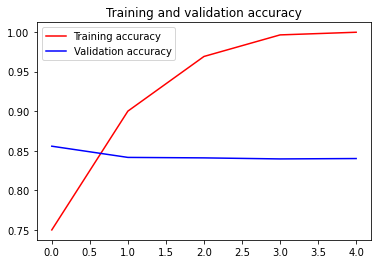

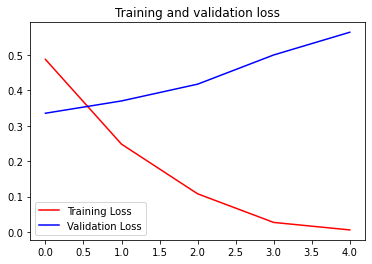

In [46]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()